<h2> Importing required libraries </h2>

In [1]:
!pip install barbar

In [2]:
import os

import datasets
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from pathlib import Path
import time
from tqdm.notebook import tqdm
from barbar import Bar
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import nltk.translate.bleu_score as bleu
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor, GPT2LMHeadModel
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator, GPT2Tokenizer
from transformers import AdamW, get_linear_schedule_with_warmup


if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

warnings.filterwarnings('ignore')
    
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from keras.regularizers import l2
from keras.models import load_model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.backend import expand_dims
from tensorflow import concat
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM,Layer,Dropout,GRU
from tensorflow.keras.models import Model
from tensorflow import repeat

There are 1 GPU(s) available.
We will use the GPU: Quadro P5000


# Config

In [3]:
class config : 
    TRAIN_BATCH_SIZE = 128
    VAL_BATCH_SIZE = 128
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 3
    IMG_SIZE = (224,224)
    LABEL_MASK = -100

In [4]:
data = pd.read_pickle('/notebooks/Radiance.AI/notebooks/NLM_CXR_preprocessed.pkl')

<h2> Test train split </h2>

In [5]:
X_train, X_test = train_test_split(data, test_size = 0.2 )
X_train = X_train.iloc[:-19, :]
X_test = X_test.iloc[:-18, :]
X_train.shape, X_test.shape

((2650, 8), (650, 8))

In [36]:
old_tokenizer = AutoTokenizer.from_pretrained("gpt2")
old_tokenizer.pad_token = '<|pad|>'
#old_tokenizer.pad_token_id = -100
old_tokenizer.eos_token = '<|endoftext|>'
old_tokenizer.bos_token = '<|startoftext|>'
tokenizer = old_tokenizer.train_new_from_iterator(data['findings'], 52000)
vocab_size_imp = len(tokenizer)
tokenizer.save_pretrained("med_reports_tokenizer")

#tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

('med_reports_tokenizer/tokenizer_config.json',
 'med_reports_tokenizer/special_tokens_map.json',
 'med_reports_tokenizer/vocab.json',
 'med_reports_tokenizer/merges.txt',
 'med_reports_tokenizer/added_tokens.json',
 'med_reports_tokenizer/tokenizer.json')

In [37]:
len(tokenizer.vocab)

3994

In [38]:
tokenizer.convert_ids_to_tokens(0)

'<|endoftext|>'

In [39]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.vocab = tokenizer.vocab
        self.max_length = 76
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.findings.iloc[idx]
        image = self.df.image1.iloc[idx]
        img_path = os.path.join(self.root_dir , image)
        img = Image.open(img_path).convert("RGB")
        
        if self.transform is not None:
            img = self.transform(img)
            #img = torch.tensor(img.numpy().transpose((1,2,0)))

        encodings_dict = self.tokenizer('<|startoftext|> '+caption + ' <|endoftext|>',
                                 padding='max_length',
                                 truncation=True,
                                 max_length=self.max_length)
        captions = encodings_dict.input_ids
        attn_mask = encodings_dict.attention_mask
        #captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {"path": image, "image": img, "caption": torch.tensor(captions), "mask": torch.tensor(attn_mask)}
        return encoding

In [40]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # mean of ImageNet dataset(for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]   # std of ImageNet dataset(for normalization)

# Tranform data
normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
transform_list = [transforms.Resize(config.IMG_SIZE), transforms.ToTensor()]

# transformList.append(transforms.RandomResizedCrop(imgtransCrop))
# transformList.append(transforms.RandomHorizontalFlip())
# transformList.append(normalize)
transform_sequence = transforms.Compose(transform_list)

In [41]:
train_dataset = ImgDataset(X_train, root_dir = "",tokenizer=tokenizer,transform = transform_sequence)
val_dataset = ImgDataset(X_test , root_dir = "",tokenizer=tokenizer, transform  = transform_sequence)

In [42]:
train_dataset.__getitem__(1)['caption'].shape, train_dataset.__getitem__(1)['mask'].shape

(torch.Size([76]), torch.Size([76]))

# Dataloaders

In [43]:
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = config.TRAIN_BATCH_SIZE
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = config.VAL_BATCH_SIZE
        )

#vocab_size
vocab_size = len(train_dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [44]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std*inp + mean
    #inp = np.clip(inp,0,1)
    plt.imshow(inp)
    plt.grid(False)
    if title is not None:
        plt.title = title
    plt.pause(0.001)

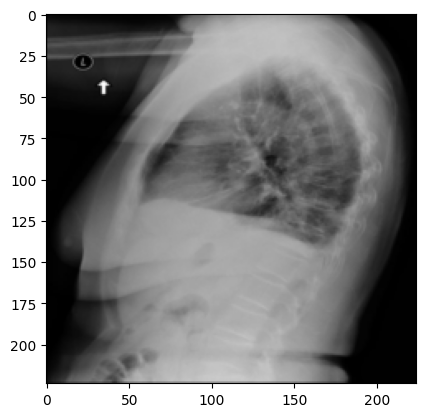

<|startoftext|> low lung volumes. elevation of the right hemidiaphragm. patchy opacities right base again noted. left lung clear. heart size top normal. aortic calcification. granulomas. no evidence of pneumothora. blunting of the bilateral costophrenic. degenerative changes of the thoracic spine. 




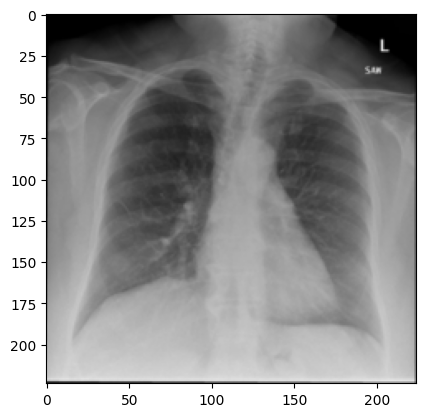

<|startoftext|> calcified granulomata are present in the right middle lobe and right upper lobe. these are unchanged since the previous eamination. both lungs are free of active infiltrates. heart size normal. 




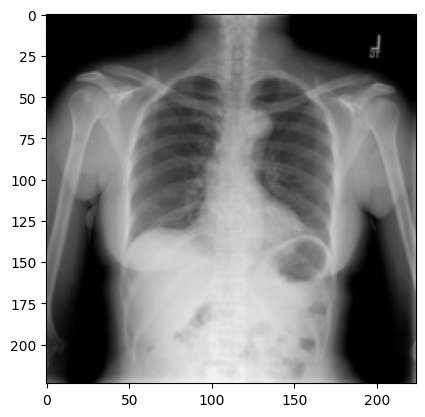

<|startoftext|> the trachea is midline. the cardiomediastinal silhouette is normal. there are low lung volumes, causing bibasilar atelectasis and bronchovascular crowding. there is a opacity in the left lingula. there is no pleural effusion or pneumothora. visualized bony structures reveal no acute abnormalities. 




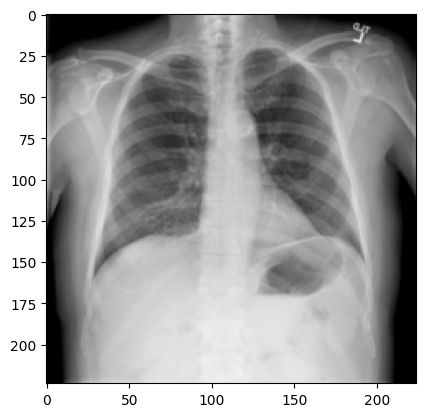

<|startoftext|> the lungs are clear. no pleural effusion is identified. the heart is normal. there are calcifications of the aortic. the skeletal structures are normal. 




In [45]:
samples = next(iter(train_dataloader))
for i, sample_output in enumerate(samples['caption'][:4]):
    imshow(samples['image'][i])
    print(tokenizer.decode(sample_output, skip_special_tokens=True) + "\n\n")

### 3) Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

# Encoder

In [46]:
tokenizer.convert_ids_to_tokens(1002)

'Ġdeformity'

In [47]:
class ResNet101(nn.Module):
    def __init__(self, out_size):
        super(ResNet101, self).__init__()
        self.resnet101 = models.resnet101()
        num_ftrs = self.resnet101.fc.in_features
        self.resnet101.fc = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.resnet101(x)
        return x
    
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = ResNet101(14)
        resnet = torch.nn.DataParallel(resnet)
        resnet.load_state_dict(torch.load("/notebooks/Radiance.AI/notebooks/weights101.pth"))
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.module.resnet101.children())[:-2]
        self.resnet101 = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet101(images)                                    #(batch_size,2048)
        #print(f"features {features.shape}")
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        #print(f"features permute {features.shape}")
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        #print(f"features vview {features.shape}")
        return features

In [48]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights
        

In [49]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=76,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.bos_token_id).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <|endoftext|> detected
            if vocab.eos_token_id == predicted_word_idx.item():
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return vocab.decode(captions, skip_special_tokens=True),alphas
    
    
    def init_hidden_state(self, encoder_out):
        #print(f"encoder_out {encoder_out.shape}")
        mean_encoder_out = encoder_out.mean(dim=1)
        #print(f"mean_encoder_out {mean_encoder_out.shape}")
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        #print(f"h {h.shape}")
        c = self.init_c(mean_encoder_out)
        #print(f"c {c.shape}")
        return h, c


In [50]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(train_dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        #print(f"features {features.shape}")
        outputs = self.decoder(features, captions)
        return outputs

In [51]:
#Hyperparams
embed_size=300
vocab_size = len(train_dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [52]:
#init model
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size = vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.tokenizer.pad_token_id)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [64]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':vocab_size,
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'resnet_attention_stateV3.pth')

## 5) Training Job from above configs

  0%|          | 0/51 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch: 50 loss: 0.91619


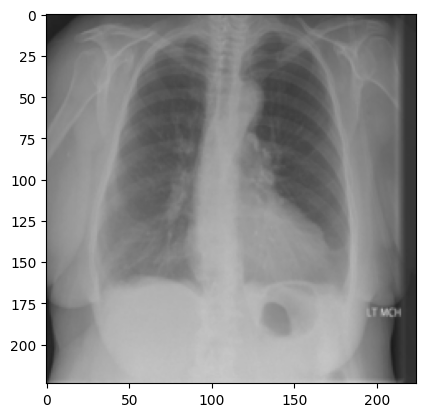

<|startoftext|> hyperepanded lungs suggesting obstructive lung disease. sequelae of old granulomatous disease. no focal airspace disease. no pleural effusions or pneumothoraces. heart and mediastinum of normal size and contour. degenerative changes in the spine. 
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear. there is no focal consolidation, pneumothora, or pleural effusion. there are degenerative changes of the thoracic spine..  of the thora are noted., consistent with chronic granulomatous disease..  of the thora., consistent with


0it [00:00, ?it/s]

Epoch: 51 loss: 0.72789
|startoftext|> the lungs are clear bilaterally. specifically, no evidence of focal consolidation, pneumothora, or pleural effusion. cardio mediastinal silhouette is unremarkable. visualized osseous structures of the thora are without acute abnormality. .  of the thora., consistent with chronic granulomatous disease.  are noted..  of the thora.,


0it [00:00, ?it/s]

Epoch: 52 loss: 0.74534
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear. there is no focal air space opacity. no pleural effusion or pneumothora. the are unremarkable. . .  of the thora are noted., consistent with chronic granulomatous disease.  degenerative changes.  of the spine. 


0it [00:00, ?it/s]

Epoch: 53 loss: 0.67340
|startoftext|> the lungs are clear. there is no focal consolidation. there are no nodules or masses. heart size and mediastinal contour are normal. the are unremarkable.. .  of the thora are noted., consistent with chronic granulomatous disease.  degenerative changes.  of the thoracolumbar spine., consistent with chronic granulomatous


0it [00:00, ?it/s]

Epoch: 54 loss: 0.74362
|startoftext|> the lungs are clear. there is no focal consolidation. there are no focal air space consolidation. no pleural effusion or pneumothora. the heart is normal..  are unremarkable..  of the thora are grossly intact..  of the thora are without acute abnormality.  degenerative changes of the spine..


0it [00:00, ?it/s]

Epoch: 55 loss: 0.57284
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear..  are noted., right upper lobe, consistent with chronic granulomatous disease. there are degenerative changes of the spine..  of the thora., consistent with chronic granulomatous disease.  of the thora.  vertebral bodies


0it [00:00, ?it/s]

Epoch: 56 loss: 0.62030
|startoftext|> the lungs are clear bilaterally. specifically, no evidence of focal consolidation, pneumothora, or pleural effusion. cardio mediastinal silhouette is unremarkable. visualized osseous structures of the thora are without acute abnormality. .  of the thora are without acute abnormality. .  consistent with chronic granulomatous disease.  are noted.. 


0it [00:00, ?it/s]

Epoch: 57 loss: 0.54112
|startoftext|> the lungs are clear. there is no focal consolidation. there are no focal air space consolidation. the heart size is normal..  of the thora.  consistent with chronic granulomatous disease.  of normal..  noted., consistent with chronic granulomatous disease.  of the thora., consistent with chronic


0it [00:00, ?it/s]

Epoch: 58 loss: 0.55685
|startoftext|> the lungs are clear bilaterally. specifically, no evidence of focal consolidation, pneumothora, or pleural effusion. cardio mediastinal silhouette is unremarkable. visualized osseous structures of the thora are without acute abnormality. .  consistent with chronic granulomatous disease.  noted.  are noted., right upper quadrant., consistent with chronic granulomatous


0it [00:00, ?it/s]

Epoch: 59 loss: 0.59067
|startoftext|> the lungs are clear. there is no focal consolidation. there are no focal air space opacity. the heart size is normal..  are noted.  are noted., consistent with chronic granulomatous disease.  are noted..  of the thora are without acute abnormality.  degenerative changes of the spine. 


0it [00:00, ?it/s]

Epoch: 60 loss: 0.61042
|startoftext|> the lungs are clear. there is no focal consolidation. there are no focal air space consolidation. there are no nodules or masses. no visible pneumothora. the heart size is normal. stable mediastinal contours.  right upper quadrant.  of the thora.  consistent with chronic granulomatous disease.  noted..  of the thora


0it [00:00, ?it/s]

Epoch: 61 loss: 0.65427
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear. there is no focal consolidation, pneumothora, or pleural effusion. there are degenerative changes of the thoracic spine..  of the thora are noted, without focal air space.  consistent with chronic granulomatous disease.  of the right.,


0it [00:00, ?it/s]

Epoch: 62 loss: 0.55198
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.  are noted., stable right greater than left, right upper lobe. there is no pneumothora.  of the right hemidiaphragm, with mild anterior wedging of the thoracic aorta..  of the thora are without acute abnormality.  


0it [00:00, ?it/s]

Epoch: 63 loss: 0.50246
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.. there is a small right-sided pleural effusion, with left-sided rib fractures. there is mild tortuosity of the thoracic aorta..  of the thora., consistent with chronic granulomatous disease.  degenerative changes of the spine


0it [00:00, ?it/s]

Epoch: 64 loss: 0.57266
|startoftext|> the lungs are clear bilaterally. specifically, no evidence of focal consolidation, pneumothora, or pleural effusion. cardio mediastinal silhouette is unremarkable. visualized osseous structures of the thora are without acute abnormality. .  of the right upper quadrant, consistent with prior granulomatous disease..  noted., consistent with chronic granulomatous disease.


0it [00:00, ?it/s]

Epoch: 65 loss: 0.47846
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.  are noted. there is a small right upper lobe nodule, possibly. there is no pneumothora. the visualized osseous structures appear intact.   consistent with chronic granulomatous disease.  of the thora.  vertebral body.  of the thora are


0it [00:00, ?it/s]

Epoch: 66 loss: 0.54074
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.. there is a small right pleural effusion, with scarring.. no acute bony abnormality.  noted.,  of the right shoulder., stable from prior eam., stable from prior eam.  of the right


0it [00:00, ?it/s]

Epoch: 67 loss: 0.50822
|startoftext|> the lungs are clear bilaterally. specifically, no evidence of focal consolidation, pneumothora, or pleural effusion. cardio mediastinal silhouette is unremarkable. visualized osseous structures of the thora are without acute abnormality. .  of the right upper quadrant., with mild degenerative changes of the thoracic spine.., consistent with chronic granulomatous


0it [00:00, ?it/s]

Epoch: 68 loss: 0.51370
|startoftext|> there is a left-sided chest with tip approimating the left atrium. heart size normal. lungs are clear. no focal consolidation, pneumothora or large pleural effusion. negative for acute bone abnormality..  noted.,  consistent with chronic granulomatous disease.  of the thora., without acute abnormality.  of the


0it [00:00, ?it/s]

Epoch: 69 loss: 0.41862
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.. there is no evidence of focal consolidation, pneumothora., stable mediastinal..  of the thora are without acute abnormality. .  of normal.  vertebral body.  of the thora are without acute abnormality. 


0it [00:00, ?it/s]

Epoch: 70 loss: 0.46480
|startoftext|> the lungs are clear. there is no focal consolidation. there are no focal air space consolidation. there are mild degenerative changes of the thoracic spine. there is a right upper lobe granuloma.  are noted.  are noted..  consistent with chronic granulomatous disease.  noted.,  consistent with chronic granulomatous disease.


0it [00:00, ?it/s]

Epoch: 71 loss: 0.45683
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.  are noted., and right chest wall, stable with prior granulomatous disease. there is mild tortuosity of the thoracic aorta. no acute bony abnormality.  degenerative changes of the thoracic spine., consistent with chronic granulomatous disease.  of


0it [00:00, ?it/s]

Epoch: 72 loss: 0.41121
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear. there is no focal consolidation, pneumothora, or pleural effusion.  right.  are noted., consistent with chronic granulomatous disease.  of normal.  consistent with chronic granulomatous disease.  noted..  of the thora, without


0it [00:00, ?it/s]

Epoch: 73 loss: 0.41420
|startoftext|> there is a left chest with tip in the right atrium. heart size normal. lungs are clear. no focal consolidation, pneumothora or large pleural effusion.  right upper quadrant., consistent with chronic granulomatous disease.  of the thora., without acute abnormality. .  of the chest., consistent with


0it [00:00, ?it/s]

Epoch: 74 loss: 0.39681
|startoftext|> the lungs are clear bilaterally. specifically, no evidence of focal consolidation, pneumothora, or pleural effusion. cardio mediastinal silhouette is unremarkable. visualized osseous structures of the thora are without acute abnormality. .  consistent with chronic granulomatous disease.  noted.,  consistent with chronic granulomatous disease.  of the right upper quadrant,


0it [00:00, ?it/s]

Epoch: 75 loss: 0.40013
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.  are noted., stable right greater than left, right th rib., stable from prior eam..  noted., right shoulder and.  consistent with chronic granulomatous disease.  noted., right shoulder


0it [00:00, ?it/s]

Epoch: 76 loss: 0.37030
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.  are clear.  right upper lobe, with a mm nodular opacity in the right upper quadrant.  are noted..  of the thora are without acute abnormality. .  consistent with chronic granulomatous disease.  noted. 


0it [00:00, ?it/s]

Epoch: 77 loss: 0.35858
|startoftext|> the lungs are clear. there is no focal consolidation. there are no focal air space opacities. there are minimal degenerative changes of the thoracic spine. the cardiomediastinal silhouette is normal.  are noted.  consistent with chronic granulomatous disease. the are grossly intact.  noted., right upper quadrant, with mild anterior wedging of the


0it [00:00, ?it/s]

Epoch: 78 loss: 0.40400
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.. there is an mm nodular opacity in the right upper lobe, consistent with chronic granulomatous disease. the lungs are grossly clear.  of normal., right upper quadrant, with fracture of t., consistent with chronic granulomatous disease.


0it [00:00, ?it/s]

Epoch: 79 loss: 0.39065
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. there are atherosclerotic changes of the aorta. there is aortic vascular markings. the lungs are well aerated. there is no focal airspace consolidation, pneumothora, or pleural effusion. stable right lower lobe.  are normal.  noted.  of the lungs are noted.,


0it [00:00, ?it/s]

Epoch: 80 loss: 0.35510
|startoftext|> the lungs are clear. there is no focal consolidation. there is no evidence of pneumothora. cardiomediastinal silhouette is normal. the skeletal structures are normal.   consistent with chronic granulomatous disease.  of the right shoulder consistent with chronic granulomatous disease.  noted.., consistent with chronic granulomatous disease.  of the chest.


0it [00:00, ?it/s]

Epoch: 81 loss: 0.37296
|startoftext|> the lungs are clear bilaterally. specifically, no evidence of focal consolidation, pneumothora, or pleural effusion. cardio mediastinal silhouette is unremarkable. visualized osseous structures of the thora are without acute abnormality. .  vertebral body.  of the thoracolumbar spine., consistent with chronic granulomatous disease.  of the right shoulder.,


0it [00:00, ?it/s]

Epoch: 82 loss: 0.30929
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear. there is no focal airspace disease. no pneumothora or pleural effusion.  are noted., consistent with chronic granulomatous disease.  of the chest., consistent with chronic granulomatous disease.  of the chest., consistent with chronic granulomatous


0it [00:00, ?it/s]

Epoch: 83 loss: 0.33148
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear. there is no focal airspace disease, pneumothora, or pleural effusion.  are identified.  consistent with chronic granulomatous disease.  are noted., right upper quadrant..  of the thora, with mild degenerative change of the thoracolumbar spine


0it [00:00, ?it/s]

Epoch: 84 loss: 0.29583
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear. there is no focal airspace disease. no pleural effusion or pneumothora.  noted.  of the right upper quadrant, consistent with prior granulomatous disease..  consistent with chronic granulomatous disease.  noted..  of the thora, without


0it [00:00, ?it/s]

Epoch: 85 loss: 0.37936
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. there are atherosclerotic calcifications of the aortic. the lungs are clear. there is no focal consolidation, pneumothora, or pleural effusion. there are degenerative changes of the thoracic spine..  noted., right upper quadrant, with old fracture..  noted.


0it [00:00, ?it/s]

Epoch: 86 loss: 0.29467
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the aorta is tortuous, with mild atherosclerotic calcification. there is a small left pleural effusion. no focal airspace consolidation. no pneumothora or large pleural effusion.  unremarkable..  noted., right upper quadrant, with old fractures..  of the thora


0it [00:00, ?it/s]

Epoch: 87 loss: 0.29063
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear. there is no focal airspace disease. no pneumothora or pleural effusion. .  consistent with chronic granulomatous disease.  noted.  noted noted., right shoulder consistent with chronic granulomatous disease.  noted..  of the thora


0it [00:00, ?it/s]

Epoch: 88 loss: 0.33037
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the aorta is tortuous aorta. there is a small area of focal area, right effusion, or focal airspace disease. there is no pneumothora or pleural effusion. the left lung parenchyma. mild degenerative changes of the thoracic spine..  noted., right upper quadrant


0it [00:00, ?it/s]

Epoch: 89 loss: 0.27059
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the aorta is atherosclerotic calcifications. the lungs are clear. there is no focal infiltrate, effusion, or pneumothora. there are degenerative changes of the spine with prior granulomatous disease..  are noted..  of the thora are noted, without acute abnormality. 


0it [00:00, ?it/s]

Epoch: 90 loss: 0.26896
|startoftext|> the lungs are clear. there is no focal consolidation. there are calcified granulomas identified. the heart size is normal. mediastinal silhouette is unremarkable.  of the thora. are grossly intact.  right upper quadrant.  noted., consistent with chronic granulomatous disease.  of the lungs.  are noted..  consistent


0it [00:00, ?it/s]

Epoch: 91 loss: 0.26543
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. there are atherosclerotic changes of the aorta. sternotomy are noted with prior granulomatous disease. the lungs are otherwise clear. there is no focal airspace disease. no pneumothora or pleural effusion.  degenerative changes of the thoracic spine., consistent with chronic granulomatous disease.  noted.


0it [00:00, ?it/s]

Epoch: 92 loss: 0.24666
|startoftext|> there is a left chest with tip in the right atrium. heart size normal. lungs are clear. no focal consolidation, pneumothora or large pleural effusion.  left., consistent with chronic granulomatous disease.  noted., consistent with chronic granulomatous disease.  of the right upper quadrant., with mild degenerative changes.


0it [00:00, ?it/s]

Epoch: 93 loss: 0.27201
|startoftext|> there is a left chest with tip in the right atrium. right ventricle. normal. heart size is normal. lungs are clear. there is no focal air space consolidation. no pneumothora. no large pleural effusion.  degenerative changes.  of the thoracolumbar spine., consistent with chronic granulomatous disease.  noted.  of t


0it [00:00, ?it/s]

Epoch: 94 loss: 0.24595
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the aorta is tortuous, with mild atherosclerotic calcifications. there is a right basilar airspace disease. there is no pneumothora. the lungs are clear. there is no focal consolidation. there is a calcified granuloma in the right upper lobe.  are noted..  of normal


0it [00:00, ?it/s]

Epoch: 95 loss: 0.25844
|startoftext|> heart size within normal limits. no focal alveolar consolidation, no definite pleural effusion seen. no typical findings of pulmonary edema.. there is no acute pneumothora..  of the right upper quadrant, consistent with prior granulomatous disease..  noted.., consistent with chronic granulomatous disease.  of the thoracolumbar


0it [00:00, ?it/s]

Epoch: 96 loss: 0.24866
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear. there is no focal airspace disease. no pneumothora or pleural effusion. .  noted., consistent with chronic granulomatous disease.  noted at the thoracolumbar junction.., consistent with chronic granulomatous disease.  of the right upper


0it [00:00, ?it/s]

Epoch: 97 loss: 0.26104
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear. there is no focal infiltrate. there is no pneumothora or large pleural effusion.  consistent with chronic granulomatous disease.  noted., right upper quadrant, with left chest wall.  are noted..  are noted with chronic granulomatous disease


0it [00:00, ?it/s]

Epoch: 98 loss: 0.22600
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the aorta is tortuous, with mild atherosclerotic calcifications. there is a small amount of focal area of the left midlung. no focal airspace consolidation. no pneumothora or pleural effusion. mild degenerative changes in the thoracic spine., visualized osseous structures.  are noted.,


0it [00:00, ?it/s]

Epoch: 99 loss: 0.22209
|startoftext|> there is a left midlung zone with scarring in the right ape. no focal consolidation. there is no pneumothora or large pleural effusion. the heart size and mediastinal contours are within normal limits. the lungs are free of focal airspace disease. no pleural effusion or pneumothora.  are noted..  consistent with chronic granulomatous disease. 


0it [00:00, ?it/s]

Epoch: 100 loss: 0.22769
|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear. there is no focal consolidation, pneumothora, or large pleural effusion.  are identified.  consistent with chronic granulomatous disease.  of the chest., consistent with chronic granulomatous disease.  of the chest., consistent with chronic granulomatous disease


In [65]:
num_epochs = 100
print_every = 10

for epoch in tqdm(range(50,num_epochs+1), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):   
    for idx, batch in tqdm(enumerate(iter(train_dataloader))):
        image = batch['image'].to(device)
        captions = batch['caption'].to(device)
        cap_masks = batch['mask'].to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

    print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))


    #generate the caption
    model.eval()
    with torch.no_grad():
        val_batch = next(iter(validation_dataloader))
        img = val_batch['image']
        features = model.encoder(img[0:1].to(device))
        caption,alphas = model.decoder.generate_caption(features,vocab=train_dataset.tokenizer)
        #caption = ' '.join(caps)
        if epoch == 50:
            imshow(img[0])
            print(tokenizer.decode(val_batch['caption'][0], skip_special_tokens=True))
        print(caption)

    model.train()
        
    #save the latest model
    save_model(model,epoch)

## 6 Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [57]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caption,alphas = model.decoder.generate_caption(features,vocab=val_dataset.tokenizer)
        imshow(features_tensors[0],title=caption)
        print(caption)
    
    return caption,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(50, 50))

    len_result = len(result.split())
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result,len_result, l+1)
        ax.set_title(result.split()[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

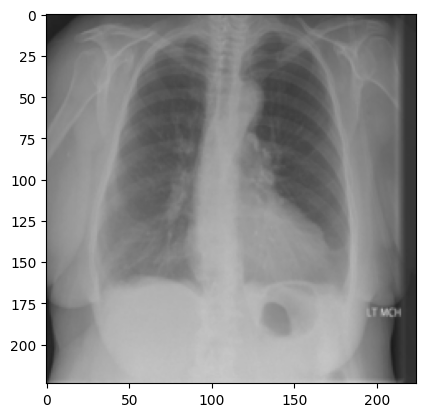

|startoftext|> the lungs are clear. there is no focal consolidation. there are no acute bony findings.. there is a right-sided chest wall. heart size and pulmonary vascularity are within normal limits.  are noted.  are noted..  of the right upper quadrant., consistent with chronic granulomatous disease.  are


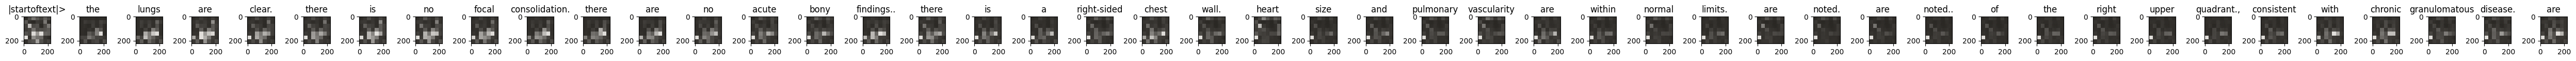

In [58]:
#show any 1
dataiter = iter(validation_dataloader)
batch = next(dataiter)

img = batch['image'][0].detach().clone()
img1 = batch['image'][0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

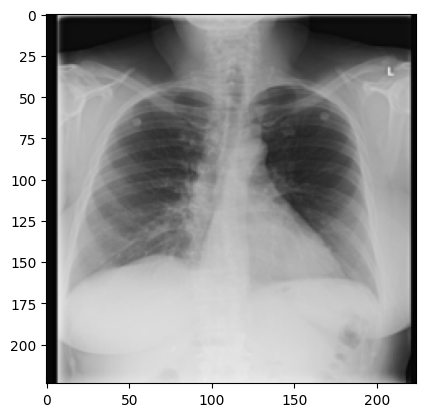

|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear.  or soft tissue neck is.  is identified..  is.  is identified noted.  is noted on the lateral view. .  spondylosis.  degenerative changes are present in the spine. .  is
<|startoftext|> the cardiac contours are normal. the lungs are clear. thoracic spondylosis. prior cholecystectomy 


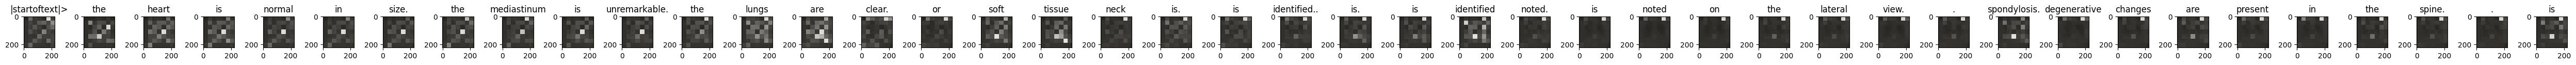

In [66]:
#show any 1
dataiter = iter(validation_dataloader)
batch = next(dataiter)
num = 10
img = batch['image'][num].detach().clone()
img1 = batch['image'][num].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))
print(tokenizer.decode(batch['caption'][num], skip_special_tokens=True))

plot_attention(img1, caps, alphas)

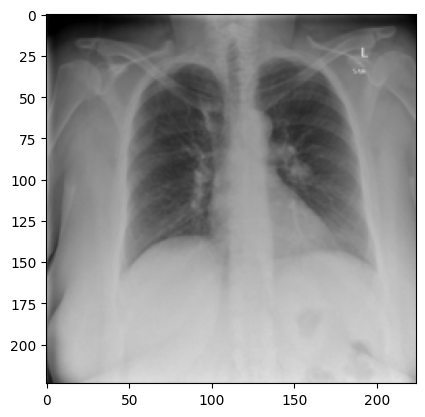

|startoftext|> redemonstration of azygos lobe. left basilar patchy infiltrate, effusion, or pneumothora. cardiomediastinal silhouette is within normal limits. no focal consolidation, pneumothora, or pleural effusion. bony thora is unremarkable. .,  of the lungs are seen.,  of the lumbar, pneumothora, or pleural spaces. no acute osseous abnormality
<|startoftext|> redemonstration of azygos lobe. redemonstrated left perihilar nodular opacity, similar in size from previous eamination. dense appearing, may be granulomatous. the trachea is midline. negative for pneumothora, pleural effusion or focal airspace consolidation. the heart size is normal.. limited eam, for evaluation of fractures. however, no evidence for displaced rib fracture.


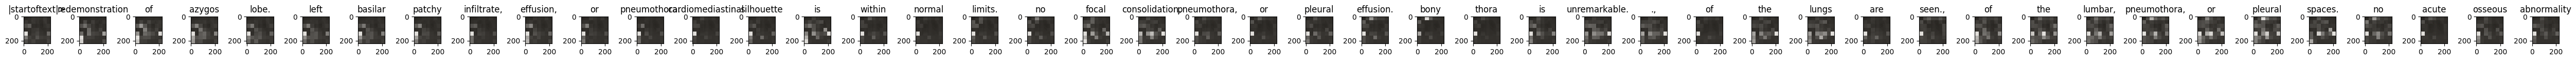

In [67]:
#show any 1
dataiter = iter(train_dataloader)
batch = next(dataiter)
num = 20
img = batch['image'][num].detach().clone()
img1 = batch['image'][num].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))
print(tokenizer.decode(batch['caption'][num], skip_special_tokens=True))

plot_attention(img1, caps, alphas)

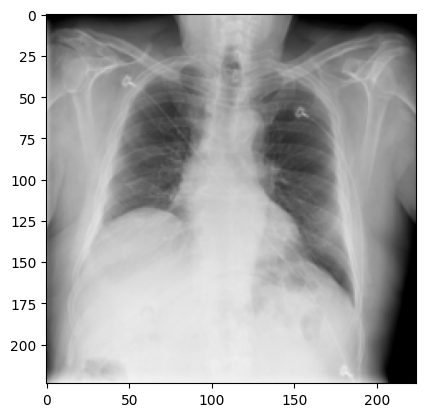

|startoftext|> the heart is normal in size. the mediastinum is unremarkable. the lungs are clear. calcified granuloma is noted. there are no acute bony findings.   noted.    noted. the  are intact.   of the left lower lobe,.  are normal. there is a calcified granuloma in the left upper
<|startoftext|> the lungs are clear. there is no pleural effusion or pneumothora. the heart is not significantly enlarged. there are atherosclerotic changes of the aorta. arthritic changes of the skeletal structures are noted. 


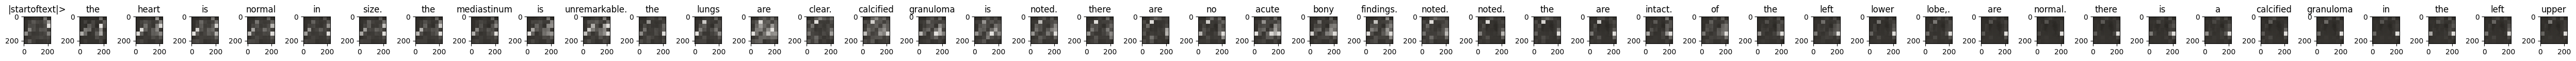

In [69]:
#show any 1
dataiter = iter(validation_dataloader)
batch = next(dataiter)
num = 100
img = batch['image'][num].detach().clone()
img1 = batch['image'][num].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))
print(tokenizer.decode(batch['caption'][num], skip_special_tokens=True))

plot_attention(img1, caps, alphas)